# Setup

## Load Libraries

In [1]:
library(caret)
library(e1071)
library(IRdisplay)
library(knitr)
library(kableExtra)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'kableExtra' was built under R version 3.6.3"Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


In [2]:
Sys.setenv(MLFLOW_BIN=system("C:/Users/ONYX/Anaconda3/envs/r-mlflow-1.13.1/Scripts/mlflow.exe"))
Sys.setenv(MLFLOW_PYTHON_BIN='C:/Users/ONYX/Anaconda3/envs/r-mlflow-1.13.1/python.exe')

## Global Configurations

In [3]:
set.seed(8888)

## Global Functions

In [4]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Negative Class (-1)', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Positive Class (+1)', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Negative Class (-1)', cex=1.2, srt=90)
  text(140, 335, 'Positive Class (+1)', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='black')
  text(195, 335, res[2], cex=1.6, font=2, col='black')
  text(295, 400, res[3], cex=1.6, font=2, col='black')
  text(295, 335, res[4], cex=1.6, font=2, col='black')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$overall[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$overall[1]), 3), cex=1.2)
  text(30, 85, names(cm$overall[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$overall[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$byClass[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$byClass[1]), 3), cex=1.4)
  text(70, 35, names(cm$byClass[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$byClass[2]), 3), cex=1.4)
}  

# Data

## Read Data and Preprocess Data

In [5]:
path <- '../data/hepatitisC.csv'
hepc.backup <- read.csv(path)
hepc <- read.csv(path)

# taking missing columns
missing_cols <- colnames(hepc)[colSums(is.na(hepc)) > 0]
missing_cols

# impute missing value with median for each columns by category
for (col in missing_cols){
    hepc[, col] <- ave(hepc[, col], 
                       hepc$Category, 
                       FUN = function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x)
                      )
}

# filter the suspect blood donor
mask <- hepc$Category != 'suspect Blood Donor'
hepc <- hepc[mask,]

# change the category
mask <- hepc$Category != 'Blood Donor'
hepc[mask, 'general_category'] <- 'Hepatitis'
hepc[!mask, 'general_category'] <- 'Blood Donor'

# remove unwanted category
hepc$Category <- factor(hepc$Category)
hepc$general_category <- factor(hepc$general_category)

summary(hepc$Category)
summary(hepc$general_category)


hepc$general_category <- c(-1, 1)[unclass(as.factor(hepc$general_category))]
hepc$general_category <- as.factor(hepc$general_category)

[1] "ALB"  "ALP"  "ALT"  "CHOL" "PROT"

Blood Donor   Cirrhosis    Fibrosis   Hepatitis 
        533          30          21          24

Blood Donor   Hepatitis 
        533          75

## Train Valid Split

In [6]:
set.seed(8888)
trainIndex <- createDataPartition(hepc$general_category, p = .7,
                                  list = FALSE,
                                  times = 1)
train <- hepc[trainIndex, ]
valid <- hepc[-trainIndex,]

## Features Selected

In [7]:
all_features <- c('Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'general_category')
selected_features <- c('AST', 'ALP', 'ALT', 'GGT', 'BIL', 'general_category')

In [8]:
train.1 <- train[, all_features]
train.2 <- train[, selected_features]

# Models

## SVM with Linear Kernel (All Features)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 157   9
        1    2  13
                                          
               Accuracy : 0.9392          
                 95% CI : (0.8939, 0.9693)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 0.005133        
                                          
                  Kappa : 0.6702          
                                          
 Mcnemar's Test P-Value : 0.070440        
                                          
            Sensitivity : 0.59091         
            Specificity : 0.98742         
         Pos Pred Value : 0.86667         
         Neg Pred Value : 0.94578         
             Prevalence : 0.12155         
         Detection Rate : 0.07182         
   Detection Prevalence : 0.08287         
      Balanced Accuracy : 0.78917         
                                          
       'Positive' Class : 1               
                              

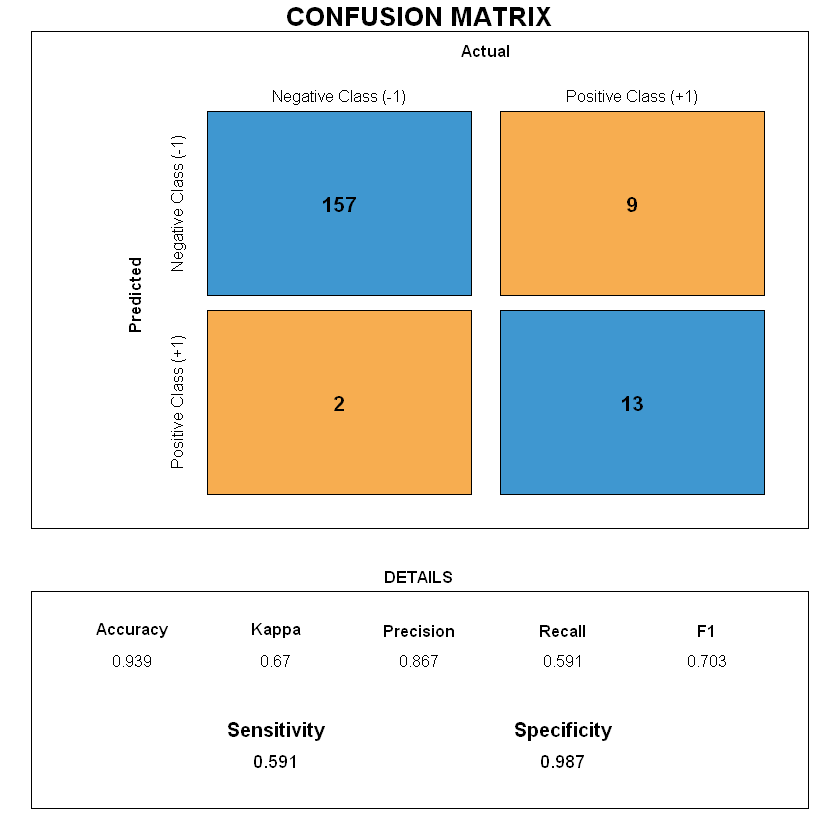

In [9]:
classifier <- svm(formula= general_category ~ ., 
                  data=train.1,
                  type='C-classification',
                  kernel='linear',
                  cross=5
                 )

y_pred <- predict(classifier, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

## SVM with Linear Kernel (Selected Features)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 158   8
        1    1  14
                                         
               Accuracy : 0.9503         
                 95% CI : (0.9077, 0.977)
    No Information Rate : 0.8785         
    P-Value [Acc > NIR] : 0.0008783      
                                         
                  Kappa : 0.7302         
                                         
 Mcnemar's Test P-Value : 0.0455003      
                                         
            Sensitivity : 0.63636        
            Specificity : 0.99371        
         Pos Pred Value : 0.93333        
         Neg Pred Value : 0.95181        
             Prevalence : 0.12155        
         Detection Rate : 0.07735        
   Detection Prevalence : 0.08287        
      Balanced Accuracy : 0.81504        
                                         
       'Positive' Class : 1              
                                         

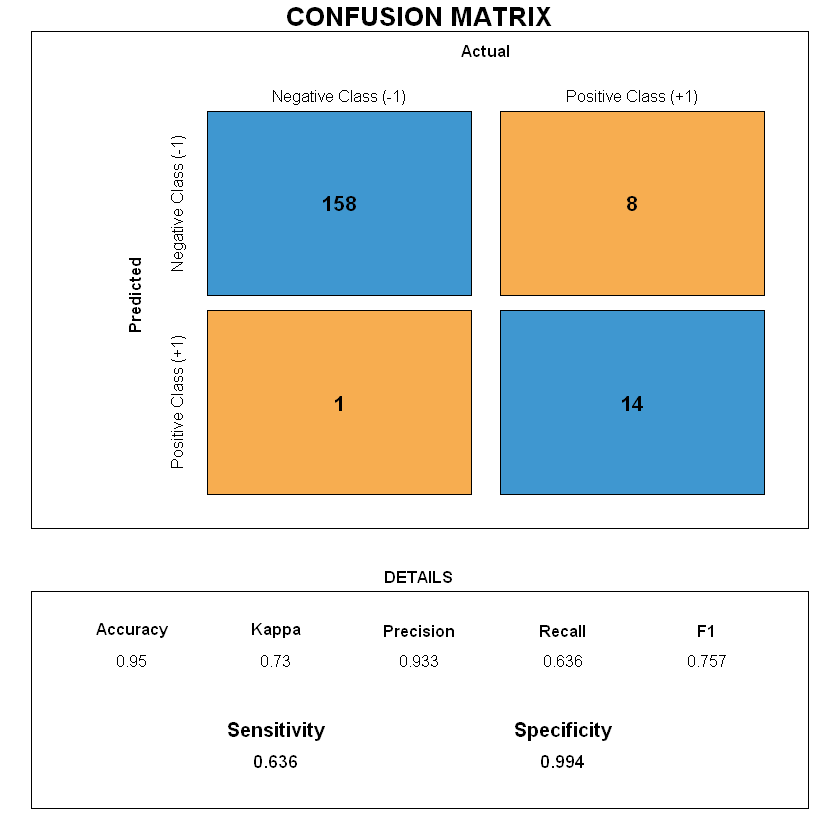

In [10]:
classifier <- svm(formula= general_category ~ ., 
                  data=train.2,
                  type='C-classification',
                  kernel='linear',
                  cross=5
                 )

y_pred <- predict(classifier, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

We can see there's obvious improvement after using only several features. Hence we will go with the one with lesser features.

## Selected Features & Class Weight

### SVM with Linear Kernel

In [11]:
weights <- 100 / table(train$general_category)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 147   1
        1   12  21
                                          
               Accuracy : 0.9282          
                 95% CI : (0.8803, 0.9612)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 0.021066        
                                          
                  Kappa : 0.7233          
                                          
 Mcnemar's Test P-Value : 0.005546        
                                          
            Sensitivity : 0.9545          
            Specificity : 0.9245          
         Pos Pred Value : 0.6364          
         Neg Pred Value : 0.9932          
             Prevalence : 0.1215          
         Detection Rate : 0.1160          
   Detection Prevalence : 0.1823          
      Balanced Accuracy : 0.9395          
                                          
       'Positive' Class : 1               
                              

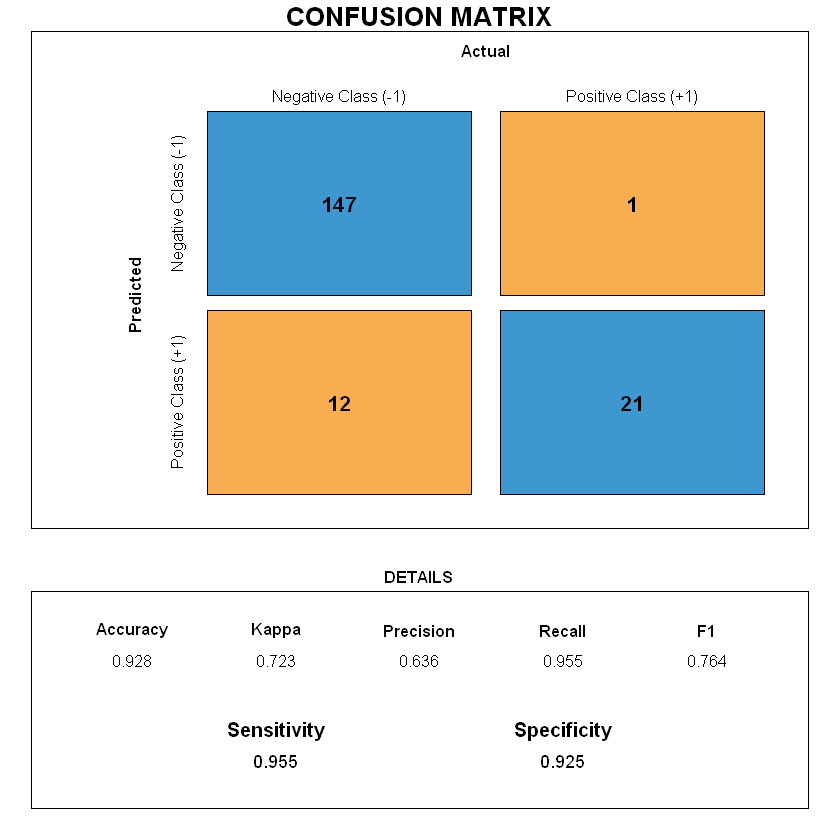

In [12]:
classifier1 <- svm(formula= general_category ~ ., 
                   data=train.2,
                   type='C-classification',
                   kernel='linear',
                   cross=5,
                   class.weights=weights
                  )

y_pred <- predict(classifier1, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

After imposing the class weights, we found out that the model is relatively accurate compare to the one without any class weight.

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 148   1
        1   11  21
                                          
               Accuracy : 0.9337          
                 95% CI : (0.8871, 0.9653)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 0.010826        
                                          
                  Kappa : 0.7404          
                                          
 Mcnemar's Test P-Value : 0.009375        
                                          
            Sensitivity : 0.9545          
            Specificity : 0.9308          
         Pos Pred Value : 0.6562          
         Neg Pred Value : 0.9933          
             Prevalence : 0.1215          
         Detection Rate : 0.1160          
   Detection Prevalence : 0.1768          
      Balanced Accuracy : 0.9427          
                                          
       'Positive' Class : 1               
                              

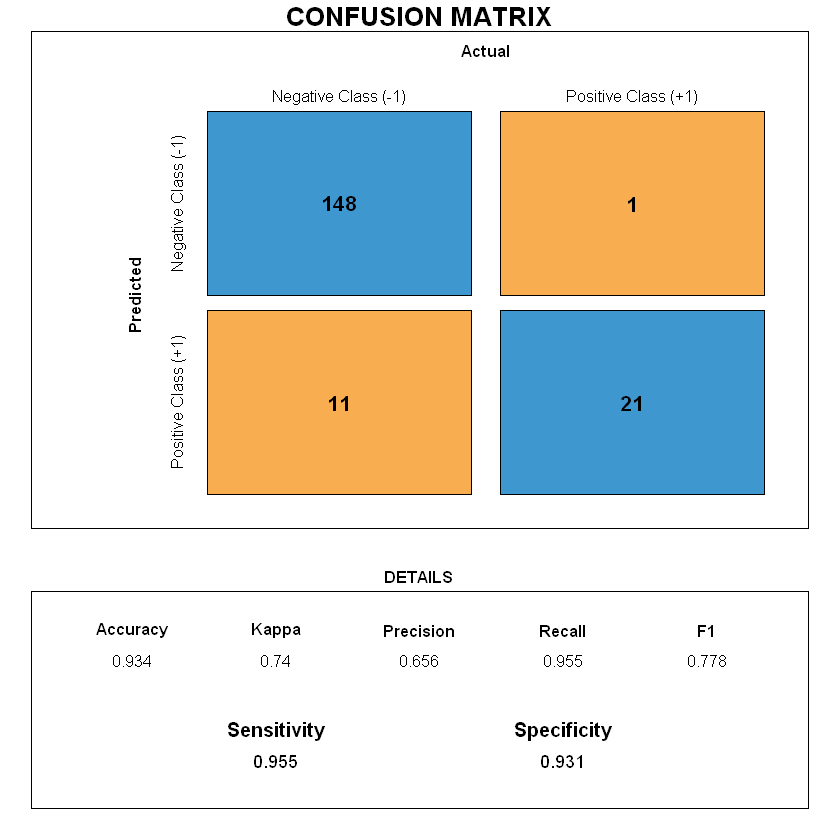

In [13]:
classifier1.cost.1000 <- svm(formula= general_category ~ ., 
                            data=train.2,
                            type='C-classification',
                            kernel='linear',
                            cross=5,
                            class.weights=weights,
                            cost=1000
                           )

y_pred <- predict(classifier1.cost.1000, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

Seems like cost = 1 and cost = 1000 got no difference, hence we will stick to cost =1

### SVM with Polynomial Kernel (Degree 2)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 145   9
        1   14  13
                                          
               Accuracy : 0.8729          
                 95% CI : (0.8155, 0.9177)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 0.6430          
                                          
                  Kappa : 0.458           
                                          
 Mcnemar's Test P-Value : 0.4042          
                                          
            Sensitivity : 0.59091         
            Specificity : 0.91195         
         Pos Pred Value : 0.48148         
         Neg Pred Value : 0.94156         
             Prevalence : 0.12155         
         Detection Rate : 0.07182         
   Detection Prevalence : 0.14917         
      Balanced Accuracy : 0.75143         
                                          
       'Positive' Class : 1               
                              

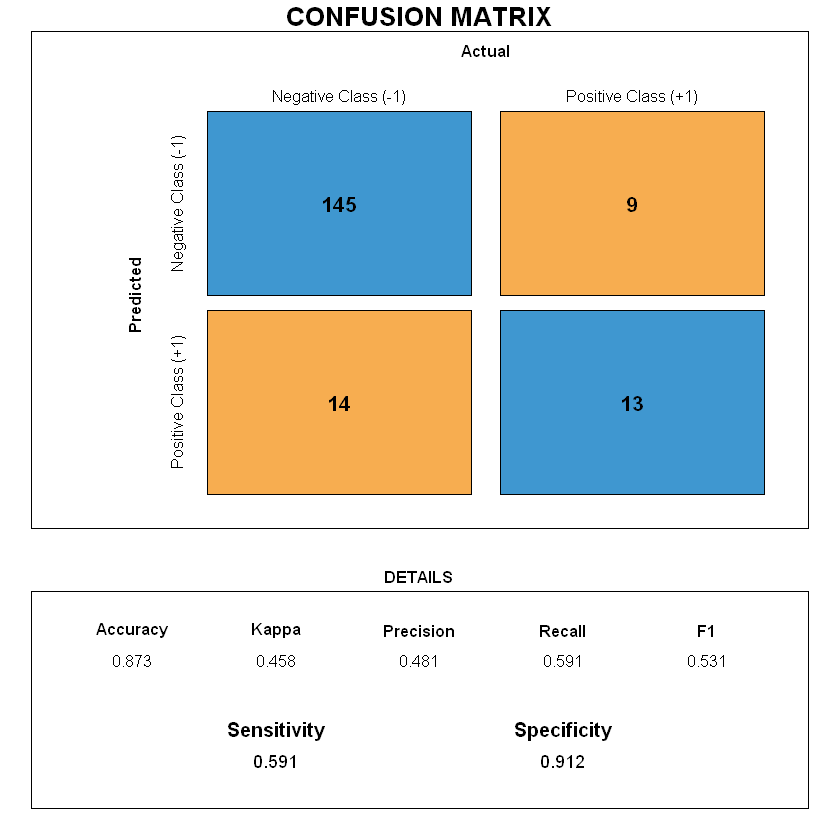

In [14]:
classifier2 <- svm(formula= general_category ~ ., 
                   data=train.2,
                   type='C-classification',
                   kernel='polynomial',
                   cross=5,
                   degree=2,
                   class.weights=weights
                  )

y_pred <- predict(classifier2, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

### SVM with Polynomial Kernel (Degree 3)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 156   6
        1    3  16
                                         
               Accuracy : 0.9503         
                 95% CI : (0.9077, 0.977)
    No Information Rate : 0.8785         
    P-Value [Acc > NIR] : 0.0008783      
                                         
                  Kappa : 0.7526         
                                         
 Mcnemar's Test P-Value : 0.5049851      
                                         
            Sensitivity : 0.7273         
            Specificity : 0.9811         
         Pos Pred Value : 0.8421         
         Neg Pred Value : 0.9630         
             Prevalence : 0.1215         
         Detection Rate : 0.0884         
   Detection Prevalence : 0.1050         
      Balanced Accuracy : 0.8542         
                                         
       'Positive' Class : 1              
                                         

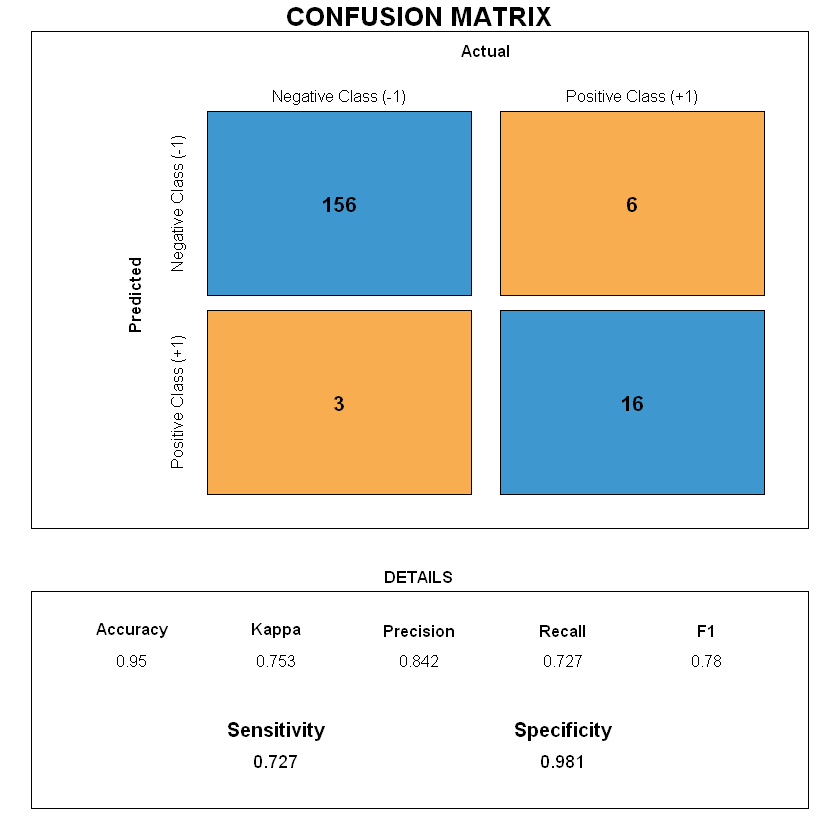

In [15]:
classifier3 <- svm(formula= general_category ~ ., 
                   data=train.2,
                   type='C-classification',
                   kernel='polynomial',
                   cross=5,
                   class.weights=weights
                  )

y_pred <- predict(classifier3, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 156   6
        1    3  16
                                         
               Accuracy : 0.9503         
                 95% CI : (0.9077, 0.977)
    No Information Rate : 0.8785         
    P-Value [Acc > NIR] : 0.0008783      
                                         
                  Kappa : 0.7526         
                                         
 Mcnemar's Test P-Value : 0.5049851      
                                         
            Sensitivity : 0.7273         
            Specificity : 0.9811         
         Pos Pred Value : 0.8421         
         Neg Pred Value : 0.9630         
             Prevalence : 0.1215         
         Detection Rate : 0.0884         
   Detection Prevalence : 0.1050         
      Balanced Accuracy : 0.8542         
                                         
       'Positive' Class : 1              
                                         

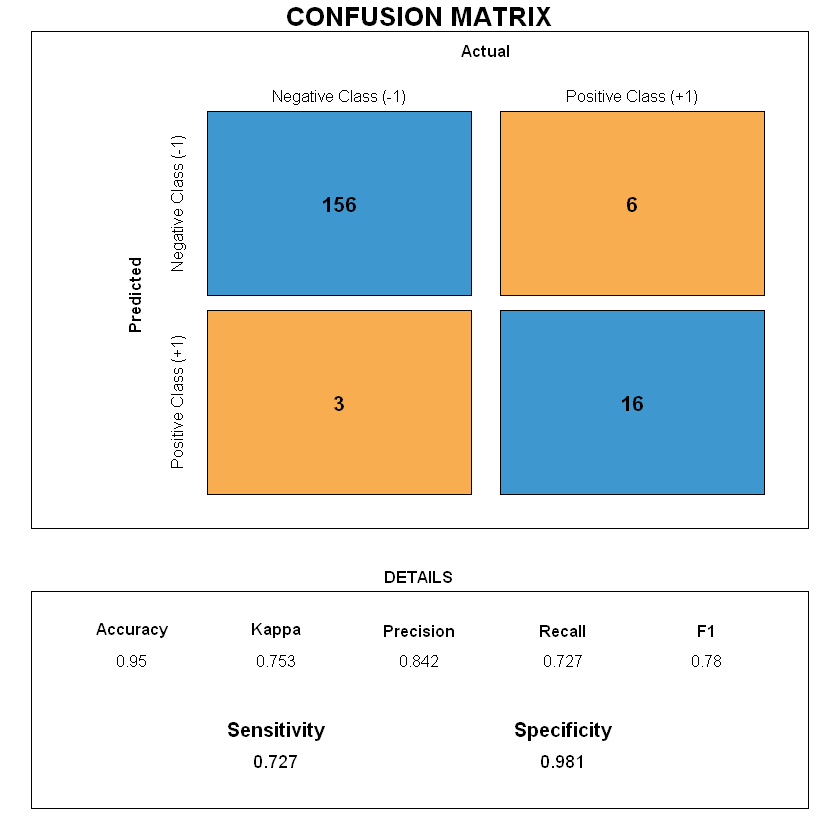

In [16]:
classifier3.cost.1000 <- svm(formula= general_category ~ ., 
                             data=train.2,
                             type='C-classification',
                             kernel='polynomial',
                             cross=5,
                             class.weights=weights,
                             C=1000
                            )

y_pred <- predict(classifier3.cost.1000, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

### SVM with Sigmoid Kernel

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 129   8
        1   30  14
                                          
               Accuracy : 0.7901          
                 95% CI : (0.7234, 0.8469)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 0.9997394       
                                          
                  Kappa : 0.3129          
                                          
 Mcnemar's Test P-Value : 0.0006577       
                                          
            Sensitivity : 0.63636         
            Specificity : 0.81132         
         Pos Pred Value : 0.31818         
         Neg Pred Value : 0.94161         
             Prevalence : 0.12155         
         Detection Rate : 0.07735         
   Detection Prevalence : 0.24309         
      Balanced Accuracy : 0.72384         
                                          
       'Positive' Class : 1               
                              

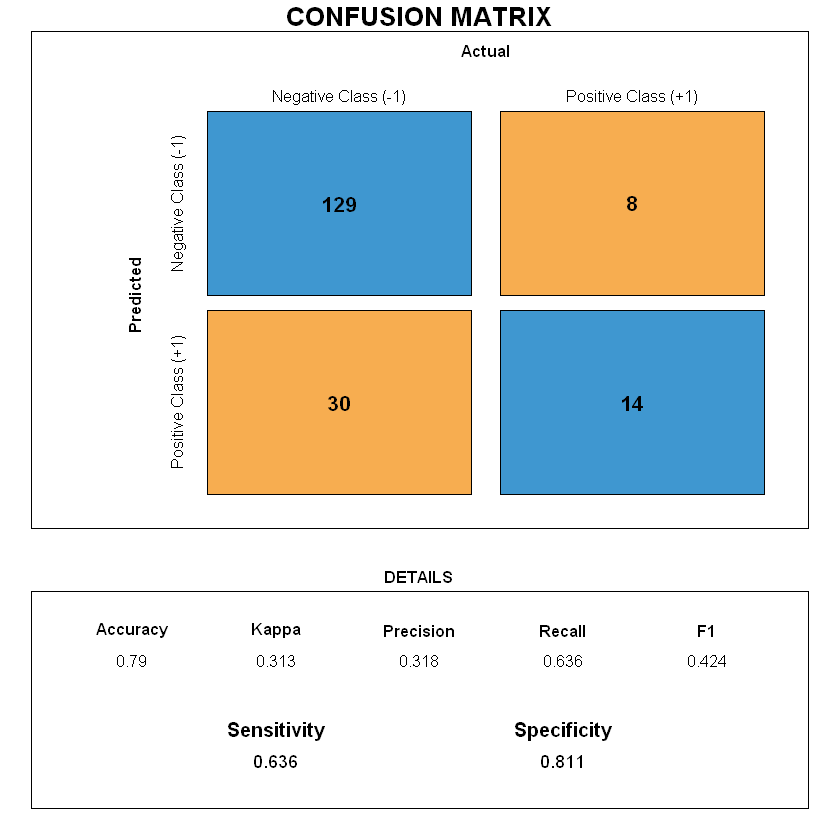

In [17]:
classifier4 <- svm(formula= general_category ~ ., 
                   data=train.2,
                   type='C-classification',
                   kernel='sigmoid',
                   cross=5,
                   class.weights=weights
                  )

y_pred <- predict(classifier4, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

### SVM with Radial Kernel

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 157   5
        1    2  17
                                          
               Accuracy : 0.9613          
                 95% CI : (0.9219, 0.9843)
    No Information Rate : 0.8785          
    P-Value [Acc > NIR] : 9.765e-05       
                                          
                  Kappa : 0.8076          
                                          
 Mcnemar's Test P-Value : 0.4497          
                                          
            Sensitivity : 0.77273         
            Specificity : 0.98742         
         Pos Pred Value : 0.89474         
         Neg Pred Value : 0.96914         
             Prevalence : 0.12155         
         Detection Rate : 0.09392         
   Detection Prevalence : 0.10497         
      Balanced Accuracy : 0.88007         
                                          
       'Positive' Class : 1               
                              

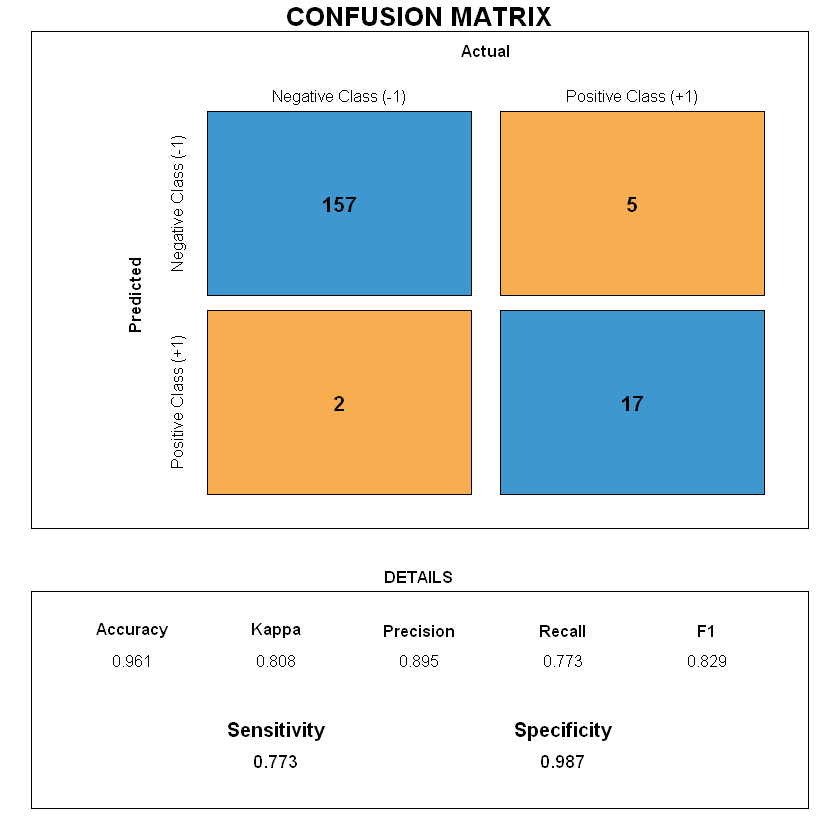

In [18]:
classifier5 <- svm(formula= general_category ~ ., 
                   data=train.2,
                   type='C-classification',
                   kernel='radial',
                   cross=5
                  )

y_pred <- predict(classifier5, newdata=valid)
cm <- confusionMatrix(y_pred, valid[, 'general_category'], positive="1")
cm
draw_confusion_matrix(cm)

# Observe Performance

## Classifier 1

In [19]:
test <- hepc.backup
missing_cols <- colnames(test)[colSums(is.na(test)) > 0]

# impute missing value with median for each columns by category
for (col in missing_cols){
    test[, col] <- ave(test[, col], 
                       test$Category, 
                       FUN = function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x)
                      )
}

# filter the suspect blood donor
mask <- test$Category != 'suspect Blood Donor'
test <- test[mask,]


# change the category
mask <- test$Category != 'Blood Donor'
test[mask, 'general_category'] <- 'Hepatitis'
test[!mask, 'general_category'] <- 'Blood Donor'

# remove unwanted category
test$Category <- factor(test$Category)
test$general_category <- factor(test$general_category)


test$general_category <- c(-1, 1)[unclass(as.factor(test$general_category))]
test$general_category <- as.factor(test$general_category)


y_pred <- predict(classifier1, test)

test[, 'predict'] = y_pred

### Cirrhosis

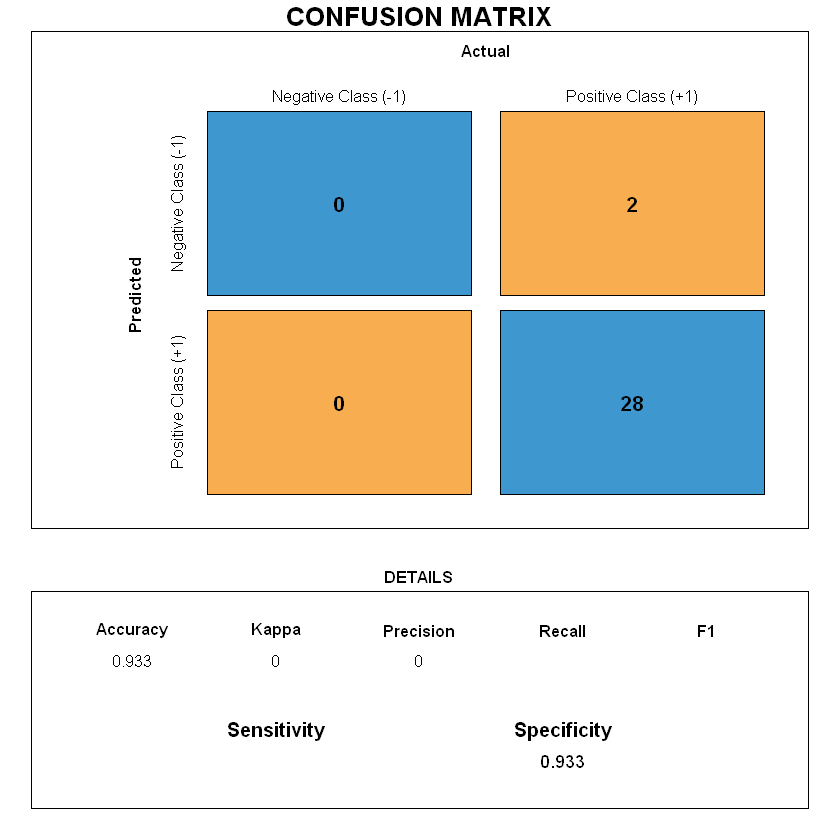

In [20]:
mask <- test$Category == 'Cirrhosis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Fibrosis

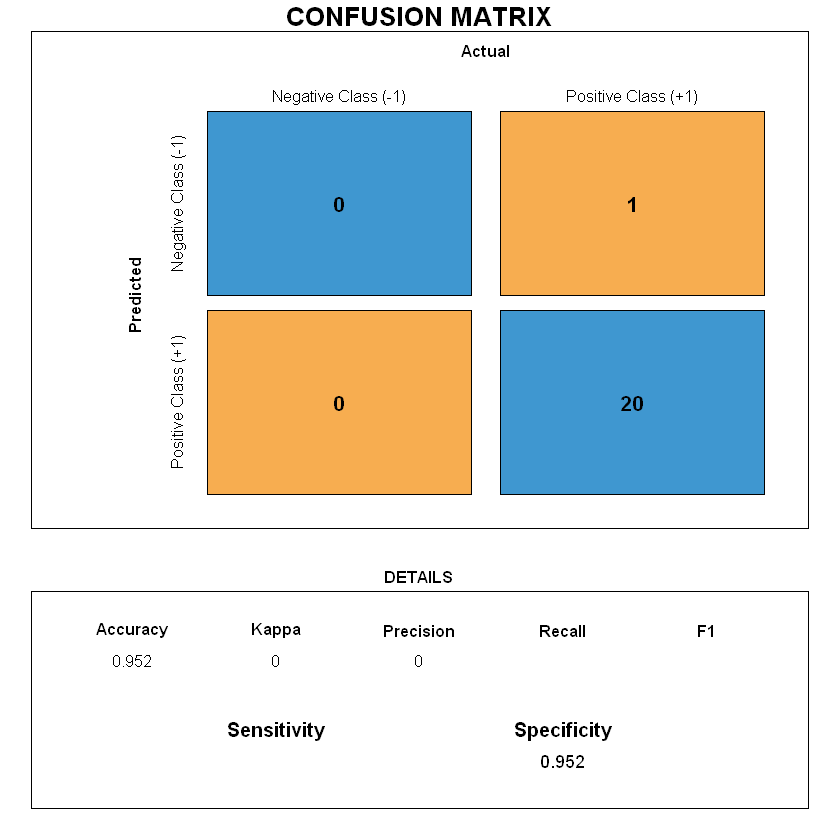

In [21]:
mask <- test$Category == 'Fibrosis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Hepatitis

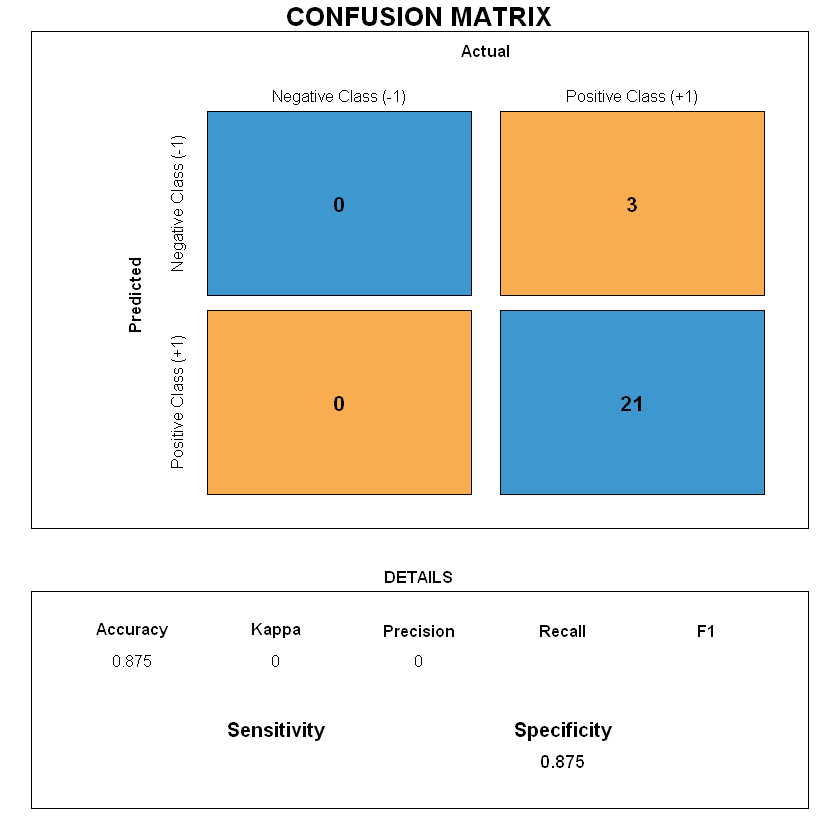

In [22]:
mask <- test$Category == 'Hepatitis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Blood Donor

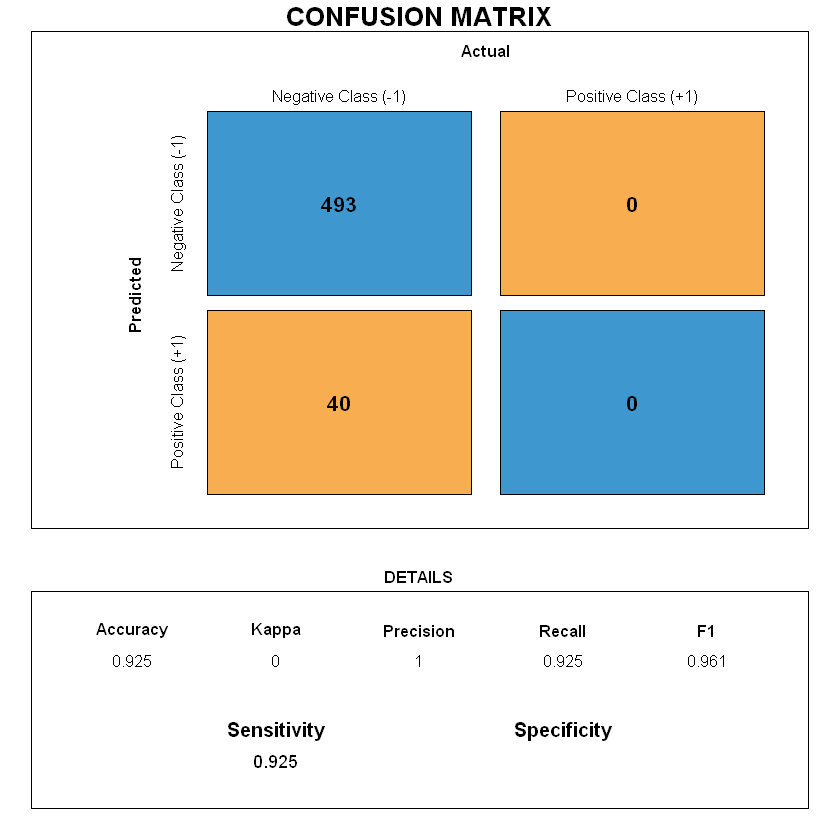

In [23]:
mask <- test$Category == 'Blood Donor'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Suspect Blood Donor

In [24]:
test <- hepc.backup
missing_cols <- colnames(test)[colSums(is.na(test)) > 0]

# impute missing value with median for each columns by category
for (col in missing_cols){
    test[, col] <- ave(test[, col], 
                       test$Category, 
                       FUN = function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x)
                      )
}

# filter the suspect blood donor
mask <- test$Category == 'suspect Blood Donor'
test <- test[mask,]
y_pred <- predict(classifier1, test)
test[, 'predict'] = y_pred

test

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,predict
534,suspect Blood Donor,47,m,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170,345.6,58.6,1
535,suspect Blood Donor,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29,83.0,47.8,-1
536,suspect Blood Donor,49,m,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64,38.9,44.8,-1
537,suspect Blood Donor,55,m,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76,71.6,78.3,1
538,suspect Blood Donor,71,m,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9,7.6,47.0,1
539,suspect Blood Donor,74,m,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52,218.3,47.8,1
540,suspect Blood Donor,59,f,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32,295.6,53.1,1


## Classifier 5

In [25]:
test <- hepc.backup
missing_cols <- colnames(test)[colSums(is.na(test)) > 0]

# impute missing value with median for each columns by category
for (col in missing_cols){
    test[, col] <- ave(test[, col], 
                       test$Category, 
                       FUN = function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x)
                      )
}

# filter the suspect blood donor
mask <- test$Category != 'suspect Blood Donor'
test <- test[mask,]


# change the category
mask <- test$Category != 'Blood Donor'
test[mask, 'general_category'] <- 'Hepatitis'
test[!mask, 'general_category'] <- 'Blood Donor'

# remove unwanted category
test$Category <- factor(test$Category)
test$general_category <- factor(test$general_category)


test$general_category <- c(-1, 1)[unclass(as.factor(test$general_category))]
test$general_category <- as.factor(test$general_category)


y_pred <- predict(classifier5, test)

test[, 'predict'] = y_pred

### Cirrhosis

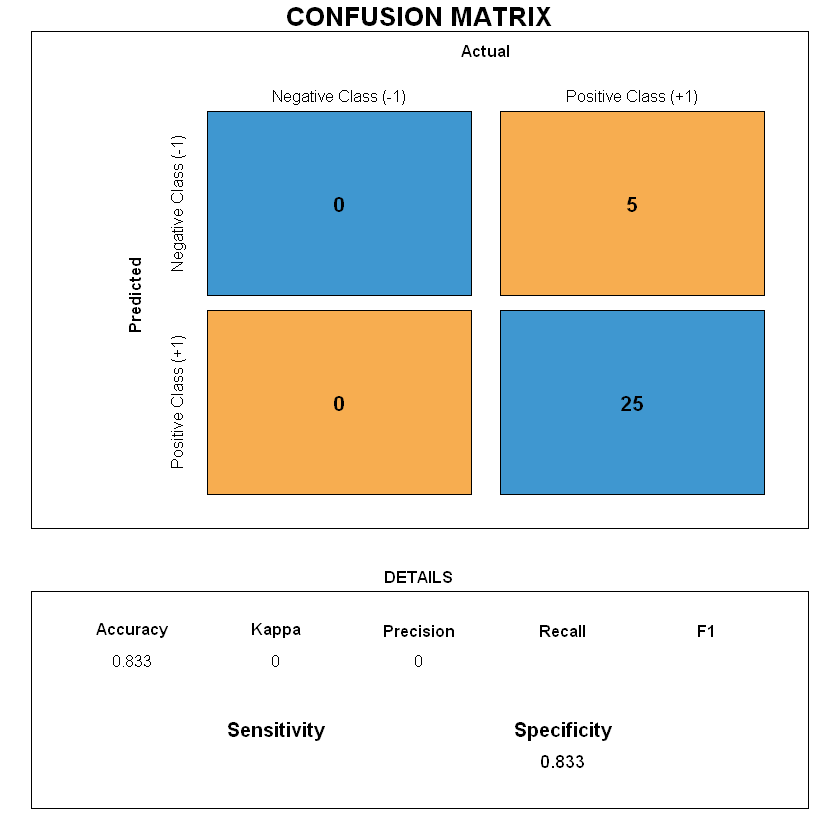

In [26]:
mask <- test$Category == 'Cirrhosis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Fibrosis

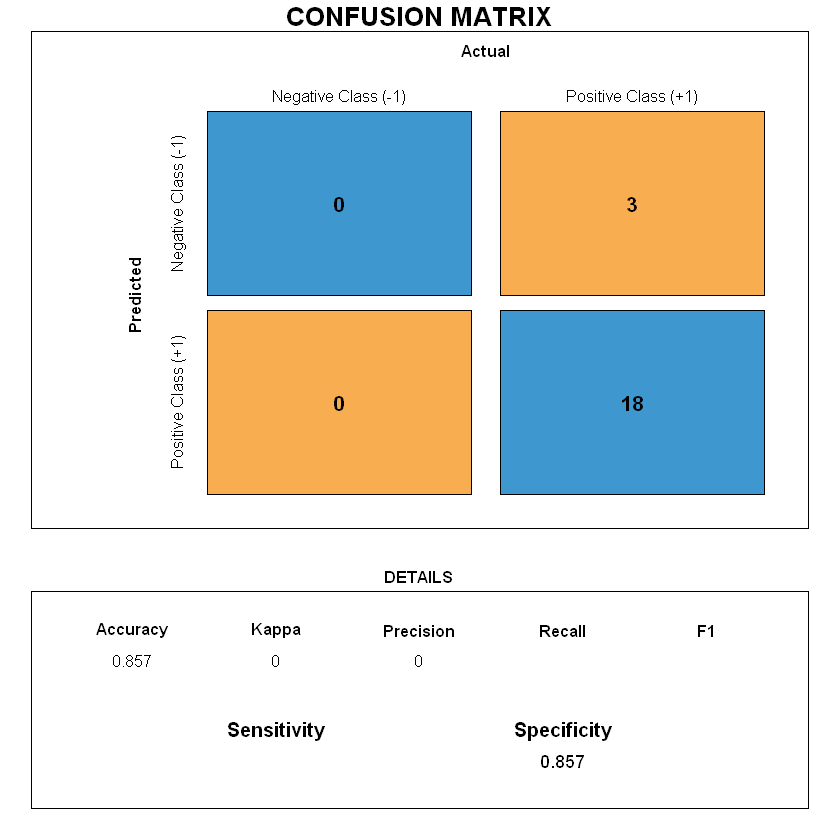

In [27]:
mask <- test$Category == 'Fibrosis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Hepatitis

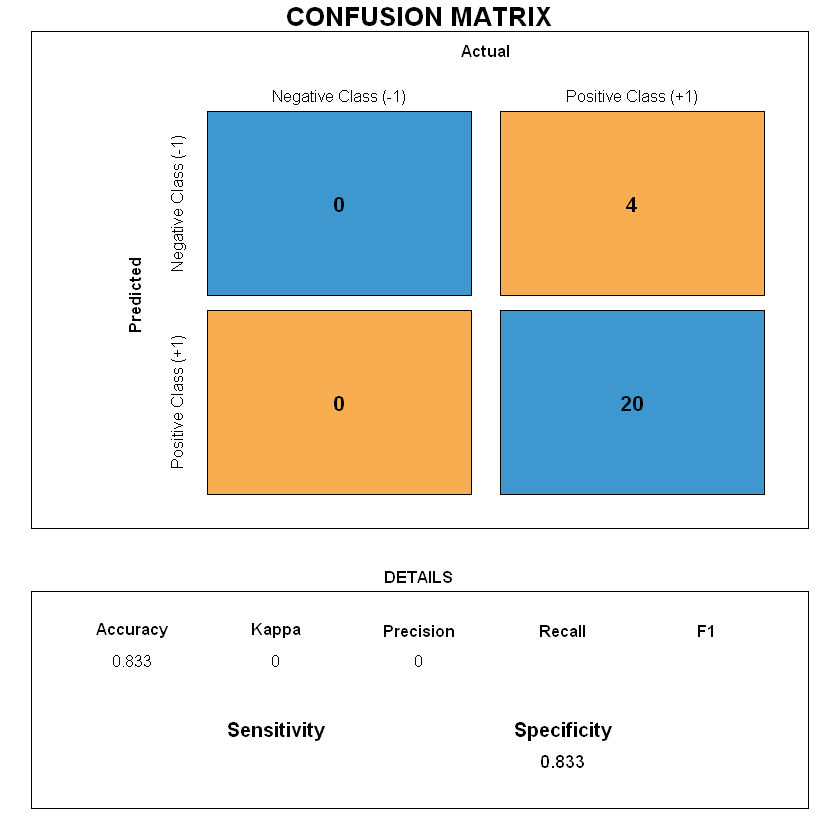

In [28]:
mask <- test$Category == 'Hepatitis'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Blood Donor

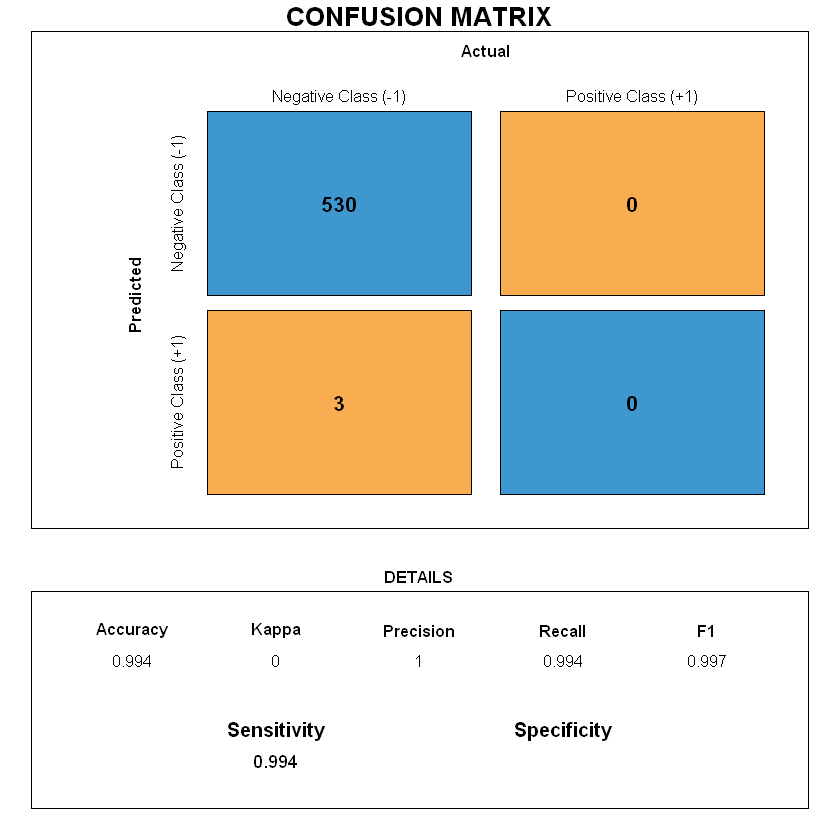

In [29]:
mask <- test$Category == 'Blood Donor'
cm <- confusionMatrix(test[mask, 'predict'], test[mask, 'general_category'])
draw_confusion_matrix(cm)

### Suspect Blood Donor

In [30]:
test <- hepc.backup
missing_cols <- colnames(test)[colSums(is.na(test)) > 0]

# impute missing value with median for each columns by category
for (col in missing_cols){
    test[, col] <- ave(test[, col], 
                       test$Category, 
                       FUN = function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x)
                      )
}

# filter the suspect blood donor
mask <- test$Category == 'suspect Blood Donor'
test <- test[mask,]
y_pred <- predict(classifier1, test)
test[, 'predict'] = y_pred

test

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,predict
534,suspect Blood Donor,47,m,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170,345.6,58.6,1
535,suspect Blood Donor,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29,83.0,47.8,-1
536,suspect Blood Donor,49,m,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64,38.9,44.8,-1
537,suspect Blood Donor,55,m,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76,71.6,78.3,1
538,suspect Blood Donor,71,m,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9,7.6,47.0,1
539,suspect Blood Donor,74,m,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52,218.3,47.8,1
540,suspect Blood Donor,59,f,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32,295.6,53.1,1
